In [163]:
import numpy as np
import matplotlib.pyplot as plt

# import time
import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.TNF import *
from nf.models import NormalizingFlowModel

from tensorboardX import SummaryWriter

from shapely.geometry import Point, Polygon
from matplotlib.animation import FuncAnimation

In [164]:
# Define fixed colormap
myCmap = plt.cm.viridis  
cmap_norm = plt.Normalize(vmin=-1, vmax=1)  # Define the range of the colormap

def plot_data(samples, isColor=False, **kwargs):

    if isColor:
        x = samples[:, 0]
        y = samples[:, 1]
        colors = samples[:, 2]    
        plt.scatter(x, y, c=colors, cmap=myCmap, alpha=0.5, s=5.5, norm=cmap_norm)
        plt.colorbar(label='alpha')
        plt.xlabel('x')
        plt.ylabel('y')

    else:
        plt.scatter(samples[:, 0], samples[:, 1], s=1, marker="o", **kwargs)    
        plt.xlabel("x")
        plt.ylabel("y")


In [165]:
argparser = ArgumentParser()
argparser.add_argument("--n", default=512, type=int)
argparser.add_argument("--flows", default=1, type=int)
argparser.add_argument("--flow", default="RealNVP", type=str)
argparser.add_argument("--iterations", default=5000, type=int)
argparser.add_argument("--use-mixture", action="store_true")
argparser.add_argument("--convolve", action="store_true")
argparser.add_argument("--actnorm", action="store_true")
args = argparser.parse_args(args=[]) 
# logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

flow = eval(args.flow)
flows = [flow(dim=2) for _ in range(args.flows)]
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
# prior = MultivariateNormal(torch.tensor([194.4821, 187.9119, 0.3752]), torch.tensor([   [42.8, 0., 0.],
#                                                                                         [0., 63.2, 0.],
#                                                                                         [0., 0., 0.37]    ]))
# prior = MultivariateNormal(torch.tensor([194.4821, 187.9119]), torch.tensor([[42.8, 0.],
#                                                                             [0., 63.2]]))
model = NormalizingFlowModel(prior, flows)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [166]:
# read the hull points from file
with open('hull_points.txt', 'r') as f:
    lines = f.readlines()
    cell_coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        cell_coords[i,0] = float(line[0]) - 194.4821
        cell_coords[i,1] = float(line[1]) - 187.9119
        # cell_coords[i,0] = float(line[0])
        # cell_coords[i,1] = float(line[1])

# print(cell_coords)

In [167]:
cutoff = 20
numchosen = 89
newx = np.zeros((cutoff*numchosen,3))
# read from file the first, second, and fourth columns
with open('new_traj_frame_wise.txt', 'r') as f:
    for i in range(cutoff*numchosen):
        line = f.readline()
        line = line.split('\t')
        # newx[i,0] = float(line[0])
        # newx[i,1] = float(line[1])
        newx[i,0] = float(line[0]) - 194.4821
        newx[i,1] = float(line[1]) - 187.9119
        newx[i,2] = float(line[3])
        # newx[i,3] = float(line[3])

newx = torch.Tensor(newx)
print('shape of newx', newx.shape)

x = newx

# numNegSamples = 27
# negSamples = np.zeros((cutoff*numNegSamples,3))
# times = np.arange(0, 1.0, 0.05)

# with open('neg_samples.txt', 'r') as f:
#     for i in range(numNegSamples):
#         line = f.readline()
#         line = line.split()
#         negSamples[i::numNegSamples,0] = float(line[0]) - 194.4821
#         negSamples[i::numNegSamples,1] = float(line[1]) - 187.9119
#         # negSamples[i::numNegSamples,2] = np.random.uniform(0, 1, cutoff)
#         negSamples[i::numNegSamples,2] = times

# print('shape of negSamples', negSamples.shape)
# # print(negSamples)
# negSamples = torch.Tensor(negSamples)

# # sample points from uniform distribution and select the ones inside the hull
# numSamples = 10000
# times = np.arange(0, 1.0, 0.05)
# samples = np.zeros((cutoff*numSamples, 3))
# polygon = Polygon(cell_coords)
# looper = 0
# while looper < numSamples:
#     candidate = np.random.uniform(-150, 150, 2)
#     point = Point(candidate)
#     if polygon.contains(point):
#         samples[looper::numSamples,0] = candidate[0]
#         samples[looper::numSamples,1] = candidate[1]
#         samples[looper::numSamples,2] = times
#         looper += 1

# samples = torch.Tensor(samples)
# print('shape of samples', samples.shape)
# x = samples

shape of newx torch.Size([1780, 3])


In [168]:
# # plot the samples
# plt.figure()
# plot_data(x[0:numSamples], isColor=False)
# plt.show()

In [169]:
# calculate the mean and covariance of the data
mean = torch.mean(x, dim=0)
cov = torch.std(x, dim=0)
print('mean:', mean)
print('cov:', cov)

mean: tensor([-3.0910e-05,  3.4742e-05,  4.7500e-01])
cov: tensor([42.8661, 63.2317,  0.2884])


In [170]:
# L2term = np.zeros((negSamples.shape[0],1))
# # print('shape of L2term', L2term.shape)

# cell_polygon = Polygon(cell_coords)
# for i in range(negSamples.shape[0]):
#     point = Point(negSamples[i,0].item(), negSamples[i,1].item())
#     # L2term[i] = cell_polygon.contains(point)
#     L2term[i] = (cell_polygon.distance(point))**2

# # convert to tensor
# L2term = torch.Tensor(L2term)
# # print(L2term)

# load the model
model = torch.load('./2Duni_10k_samples_5k_its.pth')


In [171]:
# writer = SummaryWriter('2Duni')
Loss = np.zeros([args.iterations, 1])
for i in range(args.iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det, px = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob)
    # loss += torch.mean(L2term**2)
    loss.backward()
    optimizer.step()
    Loss[i] = loss.detach().numpy()
    # writer.add_scalar('Loss', loss.item(), i)
    if i % 100 == 0:
        print("Loss at iteration", i, ":", loss.item())
        # print("L2 term at iteration", i, ":", torch.mean(L2term**2).item())
        print("Prior logprob at iteration", i, ":", torch.mean(prior_logprob).item())
        print("Log det at iteration", i, ":", torch.mean(log_det).item())
        print()
    # # negative samples
    # optimizer.zero_grad()
    # z, prior_logprob, log_det, px = model(negSamples)
    # logprob = prior_logprob + log_det
    # xval = torch.pow(10,logprob)
    # act_logprob = torch.log10(1-xval)
    # loss = -10*torch.mean(act_logprob)
    # # loss += torch.mean(L2term**2)
    # loss.backward()
    # optimizer.step()
# writer.close()
np.save('2Dloss_Ex1.npy',Loss)

Loss at iteration 0 : 10.615432739257812
Prior logprob at iteration 0 : -2.9180002212524414
Log det at iteration 0 : -7.697432041168213



Loss at iteration 100 : 10.615432739257812
Prior logprob at iteration 100 : -2.9180002212524414
Log det at iteration 100 : -7.697432041168213

Loss at iteration 200 : 10.615432739257812
Prior logprob at iteration 200 : -2.9180002212524414
Log det at iteration 200 : -7.697432041168213

Loss at iteration 300 : 10.615432739257812
Prior logprob at iteration 300 : -2.9180002212524414
Log det at iteration 300 : -7.697432041168213

Loss at iteration 400 : 10.615432739257812
Prior logprob at iteration 400 : -2.9180002212524414
Log det at iteration 400 : -7.697432041168213

Loss at iteration 500 : 10.615432739257812
Prior logprob at iteration 500 : -2.9180002212524414
Log det at iteration 500 : -7.697432041168213

Loss at iteration 600 : 10.615432739257812
Prior logprob at iteration 600 : -2.9180002212524414
Log det at iteration 600 : -7.697432041168213

Loss at iteration 700 : 10.615432739257812
Prior logprob at iteration 700 : -2.9180002212524414
Log det at iteration 700 : -7.697432041168213


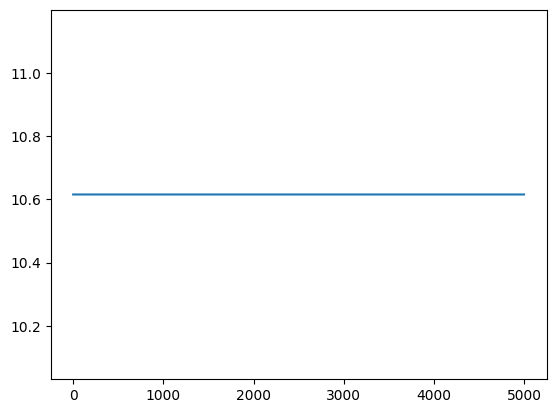

In [172]:
# plot the loss
plt.plot(Loss)

In [173]:
# load all the data from file
with open('20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt', 'r') as f:
    lines = f.readlines()
    coords = np.zeros((len(lines), 2))
    for i in range(len(lines)):
        line = lines[i].split('\t')
        coords[i,0] = float(line[2])
        coords[i,1] = float(line[3])

# # plot the data
# plt.figure()
# # plot all points
# plt.plot(coords[:,0], coords[:,1], 'o', color='black', markersize=1, alpha=0.5)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Data')
# plt.show()

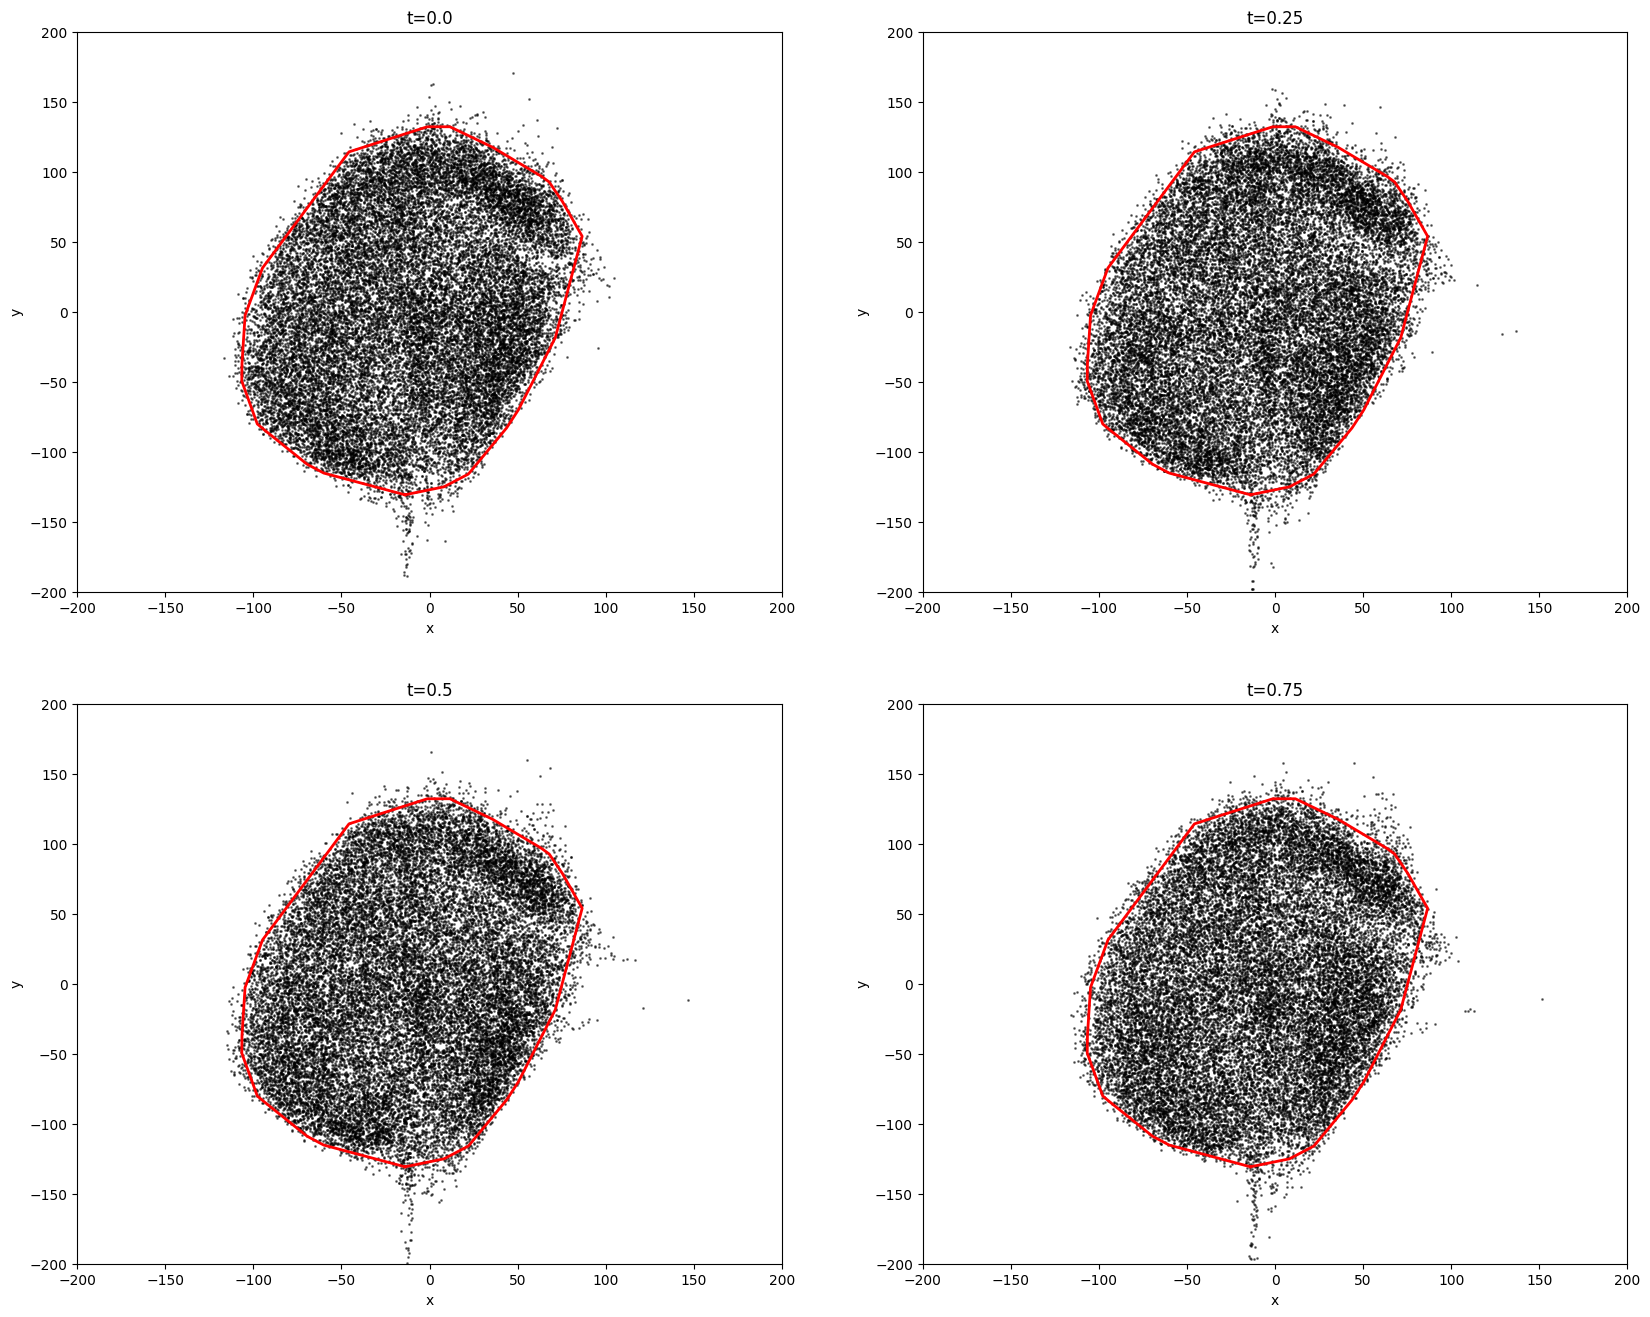

MovieWriter ffmpeg unavailable; using Pillow instead.


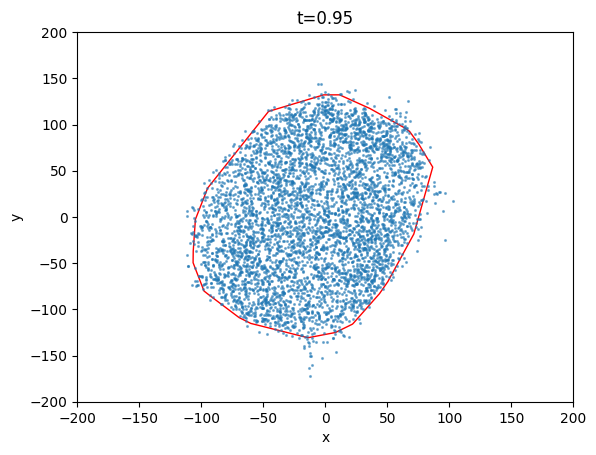

In [174]:
# position_x = np.reshape(x[:,0].detach().numpy(), (cutoff, numchosen), order='C')
# position_y = np.reshape(x[:,1].detach().numpy(), (cutoff, numchosen), order='C')

# close the polygon
cell_coords_closed = np.append(cell_coords, [cell_coords[0]], axis=0)

# Resampling
plt.figure(figsize=(20,16))

plt.subplot(2, 2, 1)
samples = model.sample(25000, t=0).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=False, color="black", alpha=0.5)
plt.xlim((-200,200))
plt.ylim((-200,200))
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.0")

plt.subplot(2, 2, 2)
samples = model.sample(25000, t=0.25).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=False, color="black", alpha=0.5)
# plt.grid()
plt.xlim((-200,200))
plt.ylim((-200,200))
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.25")

plt.subplot(2, 2, 3)
samples = model.sample(25000, t=0.5).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=False, color="black", alpha=0.5)
plt.xlim((-200,200))
plt.ylim((-200,200))
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.5")

plt.subplot(2, 2, 4)
samples = model.sample(25000, t=0.75).data
plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
plot_data(samples, isColor=False, color="black", alpha=0.5)
plt.xlim((-200,200))
plt.ylim((-200,200))
# plt.xlim((0,400))
# plt.ylim((0,400))
plt.title("t=0.75")
plt.show()

# show a gif of the distribution over time using FuncAnimation
fig, ax = plt.subplots()
ax.set_xlim((-200, 200))
ax.set_ylim((-200, 200))
# plt.xlim((0,400))
# plt.ylim((0,400))
polygon = plt.Polygon(cell_coords_closed, closed=True, fill=None, edgecolor='r')
ax.add_patch(polygon)
# sc = plt.scatter([], [], s=1.5, c=[], cmap=myCmap, alpha=0.5, norm=cmap_norm)
sc = plt.scatter([], [], s=1.5, alpha=0.5)
# plt.colorbar(sc, label='alpha')
plt.xlabel('x')
plt.ylabel('y')

def update(frame):
    samples = model.sample(5000, t=frame).data
    sc.set_offsets(samples)
    # sc.set_array(samples[:,2])
    # set title
    ax.set_title(f't={frame:.2f}')
    return sc,
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 21)[:-1], blit=True)
ani.save('2Duni.gif', fps=3)
# plt.show()



In [175]:
# # writer = SummaryWriter('2Duni')
# Loss = np.zeros([args.iterations, 1])
# for i in range(args.iterations):
#     optimizer.zero_grad()
#     z, prior_logprob, log_det, px = model(negSamples)
#     logprob = prior_logprob + log_det
#     xval = torch.pow(10,logprob)    
#     act_logprob = torch.log10(1-xval)
#     loss = -torch.mean(act_logprob)
#     # loss += torch.mean(L2term**2)
#     loss.backward()
#     optimizer.step()
#     Loss[i] = loss.detach().numpy()

#     if i % 100 == 0:
#         print('logprob:', torch.mean(logprob).item())
#         print('xval:', torch.mean(xval).item())
#         print("Loss at iteration", i, ":", loss.item())
#         # print("L2 term at iteration", i, ":", torch.mean(L2term**2).item())
#         print("Prior logprob at iteration", i, ":", torch.mean(prior_logprob).item())
#         print("Log det at iteration", i, ":", torch.mean(log_det).item())
#         print()

# # writer.close()
# # np.save('2Dloss_Ex1.npy',Loss)

In [176]:
# # position_x = np.reshape(x[:,0].detach().numpy(), (cutoff, numchosen), order='C')
# # position_y = np.reshape(x[:,1].detach().numpy(), (cutoff, numchosen), order='C')

# # close the polygon
# cell_coords_closed = np.append(cell_coords, [cell_coords[0]], axis=0)

# # Resampling
# plt.figure(figsize=(20,16))

# plt.subplot(2, 2, 1)
# samples = model.sample(25000, t=0).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=False, color="black", alpha=0.5)
# plt.xlim((-200,200))
# plt.ylim((-200,200))
# plt.title("t=0.0")

# plt.subplot(2, 2, 2)
# samples = model.sample(25000, t=0.25).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=False, color="black", alpha=0.5)
# # plt.grid()
# plt.xlim((-200,200))
# plt.ylim((-200,200))
# plt.title("t=0.25")

# plt.subplot(2, 2, 3)
# samples = model.sample(25000, t=0.5).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=False, color="black", alpha=0.5)
# plt.xlim((-200,200))
# plt.ylim((-200,200))
# plt.title("t=0.5")

# plt.subplot(2, 2, 4)
# samples = model.sample(25000, t=0.75).data
# plt.plot(cell_coords_closed[:,0], cell_coords_closed[:,1], color='red', linestyle='-', linewidth=2)
# plot_data(samples, isColor=False, color="black", alpha=0.5)
# plt.xlim((-200,200))
# plt.ylim((-200,200))
# plt.title("t=0.75")
# plt.show()

# # show a gif of the distribution over time using FuncAnimation
# fig, ax = plt.subplots()
# ax.set_xlim((-200, 200))
# ax.set_ylim((-200, 200))
# polygon = plt.Polygon(cell_coords_closed, closed=True, fill=None, edgecolor='r')
# ax.add_patch(polygon)
# # sc = plt.scatter([], [], s=1.5, c=[], cmap=myCmap, alpha=0.5, norm=cmap_norm)
# sc = plt.scatter([], [], s=1.5, alpha=0.5)
# # plt.colorbar(sc, label='alpha')
# plt.xlabel('x')
# plt.ylabel('y')

# def update(frame):
#     samples = model.sample(5000, t=frame).data
#     sc.set_offsets(samples)
#     # sc.set_array(samples[:,2])
#     # set title
#     ax.set_title(f't={frame:.2f}')
#     return sc,
# ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 21)[:-1], blit=True)
# ani.save('2Duni.gif', fps=3)
# # plt.show()



In [177]:
# save the model
torch.save(model, '2Duni.pth')

# load the model
# model = torch.load('2Duni.pth')